<a href="https://colab.research.google.com/github/ArshT/Pytorch_Practice/blob/master/Denoising_AE_FashionMNIST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import torchvision
from torchvision.transforms import transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [2]:
transform = transforms.Compose([transforms.ToTensor(),transforms.Normalize((0.5),(0.4))])

trainset = torchvision.datasets.FashionMNIST(root='./data', train=True,download=True, transform=transform)

trainloader = torch.utils.data.DataLoader(trainset,batch_size = 32,shuffle=True,num_workers=2)

testset = torchvision.datasets.FashionMNIST(root='./data', train=False,download=True, transform=transform)

testloader = torch.utils.data.DataLoader(testset,batch_size = 32,shuffle=True,num_workers=2)

In [3]:
USE_GPU = True

if USE_GPU and torch.cuda.is_available():
    print('using device: cuda')
else:
    print('using device: cpu')

device = torch.device("cuda:0" if USE_GPU else "cpu")

using device: cuda


In [10]:
class Encoder(nn.Module):

  def __init__(self):
    super(Encoder,self).__init__()

    self.conv1 = nn.Conv2d(1,32,3,(1,1),padding=(1,1))
    self.batch1 = nn.BatchNorm2d(32)
    self.conv2 = nn.Conv2d(32,64,2,(2,2))
    self.batch2 = nn.BatchNorm2d(64)
    self.conv3 = nn.Conv2d(64,128,2,(2,2))
    self.batch3 = nn.BatchNorm2d(128)
    self.conv4 = nn.Conv2d(128,128,2,(2,2))

  def forward(self,x):

    x = F.relu(self.conv1(x))
    x = self.batch1(x)
    x = F.relu(self.conv2(x))
    x = self.batch2(x)
    x = F.relu(self.conv3(x))
    x = self.batch3(x)
    x = self.conv4(x)

    return x

encoder = Encoder()
encoder = encoder.to(device)
print(encoder)

Encoder(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (batch1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(32, 64, kernel_size=(2, 2), stride=(2, 2))
  (batch2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(64, 128, kernel_size=(2, 2), stride=(2, 2))
  (batch3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv4): Conv2d(128, 128, kernel_size=(2, 2), stride=(2, 2))
)


In [11]:
class Decoder(nn.Module):

  def __init__(self):
    super(Decoder,self).__init__()

    self.t_conv1 = nn.ConvTranspose2d(128,128,3,stride=2,padding=2)
    self.batch1 = nn.BatchNorm2d(128)
    self.t_conv2 = nn.ConvTranspose2d(128,64,3,stride=2)
    self.batch2 = nn.BatchNorm2d(64)
    self.t_conv3 = nn.ConvTranspose2d(64,32, 3, stride=2, padding=1, output_padding=1)
    self.batch3 = nn.BatchNorm2d(32)
    self.t_conv4 = nn.ConvTranspose2d(32,1,3,stride = 2,padding = 1,output_padding = 1)


  def forward(self,x):

    x = F.relu(self.t_conv1(x))
    x = self.batch1(x)
    x = F.relu(self.t_conv2(x))
    x = self.batch2(x)
    x = F.relu(self.t_conv3(x))
    x = self.batch3(x)
    x = F.sigmoid(self.t_conv4(x))

    return x

decoder = Decoder()
decoder = decoder.to(device)
print(decoder)

Decoder(
  (t_conv1): ConvTranspose2d(128, 128, kernel_size=(3, 3), stride=(2, 2), padding=(2, 2))
  (batch1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (t_conv2): ConvTranspose2d(128, 64, kernel_size=(3, 3), stride=(2, 2))
  (batch2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (t_conv3): ConvTranspose2d(64, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
  (batch3): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (t_conv4): ConvTranspose2d(32, 1, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
)


In [12]:
criterion_AE = nn.MSELoss()
optimizer_encoder = torch.optim.Adam(encoder.parameters(),lr=0.0005, weight_decay=1e-5)
optimizer_decoder = torch.optim.Adam(decoder.parameters(),lr=0.0005, weight_decay=1e-5)

In [13]:
def val_loss(dataloader,criterion):

  I = 0
  total_loss = 0.0

  for data in dataloader:
    I += 1
    
    images,l = data
    images = images.to(device)

    noise = torch.tensor(np.random.normal(loc=0.5, scale=0.5, size=images.shape)).to(device)
    noisy_inputs = images + noise
    noisy_inputs = noisy_inputs.to(device,dtype=torch.float)

    z_inter = encoder(noisy_inputs)
    out = decoder(z_inter)

    loss = criterion_AE(out,images)
    total_loss += loss

  avg_loss = total_loss / I

  return avg_loss

In [14]:
Check = []
import numpy as np

for epoch in range(30):
  print("epoch",epoch+1)

  running_loss = 0.0
  for i,data in enumerate(trainloader,0):

    inputs,labels = data

    inputs = inputs.to(device)
    labels = labels.to(device)

    train_noise = torch.tensor(np.random.normal(loc=0.5, scale=0.5, size=inputs.shape)).to(device)
    noisy_inputs = inputs + train_noise
    noisy_inputs = noisy_inputs.to(device,dtype=torch.float)

    optimizer_encoder.zero_grad()
    optimizer_decoder.zero_grad()

    z = encoder(inputs)
    outputs = decoder(z)
    
    loss = criterion_AE(outputs, inputs)

    loss.backward()
    optimizer_encoder.step()
    optimizer_decoder.step()

    running_loss += loss.item()
    
    
    if i % 300 == 299:    
      print('[%d, %5d] loss: %.3f' %(epoch + 1, i + 1, running_loss / 300))
      running_loss = 0.0
  
  Check.append((epoch,noisy_inputs,outputs))
  print("")

epoch 1


/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1625: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


[1,   300] loss: 1.049
[1,   600] loss: 0.949
[1,   900] loss: 0.931
[1,  1200] loss: 0.923
[1,  1500] loss: 0.922
[1,  1800] loss: 0.915

epoch 2
[2,   300] loss: 0.917
[2,   600] loss: 0.918
[2,   900] loss: 0.904
[2,  1200] loss: 0.908
[2,  1500] loss: 0.910
[2,  1800] loss: 0.908

epoch 3
[3,   300] loss: 0.908
[3,   600] loss: 0.904
[3,   900] loss: 0.908
[3,  1200] loss: 0.907
[3,  1500] loss: 0.906
[3,  1800] loss: 0.905

epoch 4
[4,   300] loss: 0.904
[4,   600] loss: 0.906
[4,   900] loss: 0.903
[4,  1200] loss: 0.904
[4,  1500] loss: 0.902
[4,  1800] loss: 0.906

epoch 5
[5,   300] loss: 0.902
[5,   600] loss: 0.902
[5,   900] loss: 0.904
[5,  1200] loss: 0.906
[5,  1500] loss: 0.903
[5,  1800] loss: 0.901

epoch 6
[6,   300] loss: 0.903
[6,   600] loss: 0.899
[6,   900] loss: 0.905
[6,  1200] loss: 0.902
[6,  1500] loss: 0.900
[6,  1800] loss: 0.902

epoch 7
[7,   300] loss: 0.902
[7,   600] loss: 0.902
[7,   900] loss: 0.901
[7,  1200] loss: 0.903
[7,  1500] loss: 0.898
[7,

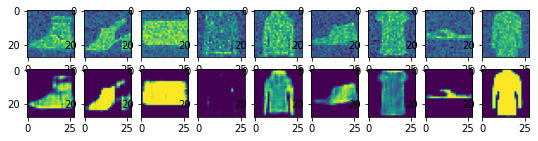

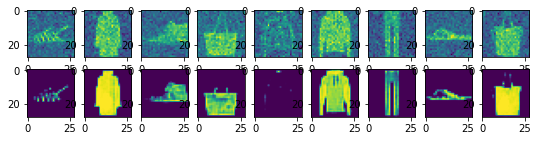

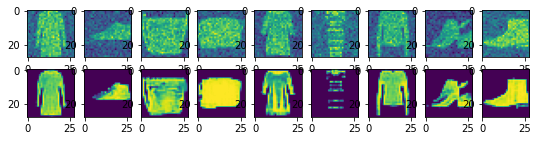

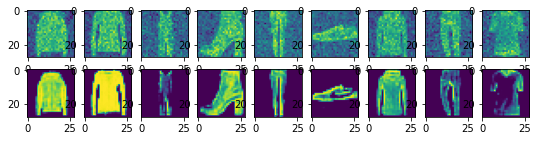

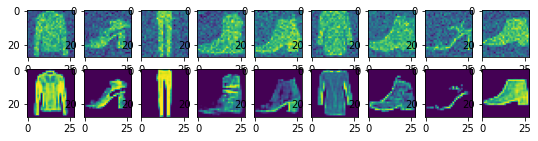

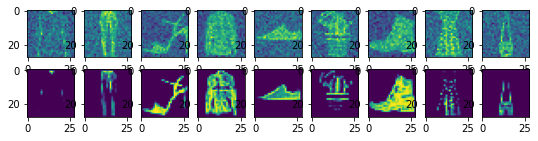

In [15]:
import matplotlib.pyplot as plt

for k in range(0, 30, 5):
    plt.figure(figsize=(9, 2))
    imgs = (Check[k][1].detach()).to('cpu').numpy()
    recon = (Check[k][2].detach()).to('cpu').numpy()
    for i, item in enumerate(imgs):
        if i >= 9: break
        plt.subplot(2, 9, i+1)
        plt.imshow(item[0])
        
    for i, item in enumerate(recon):
        if i >= 9: break
        plt.subplot(2, 9, 9+i+1)
        plt.imshow(item[0])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


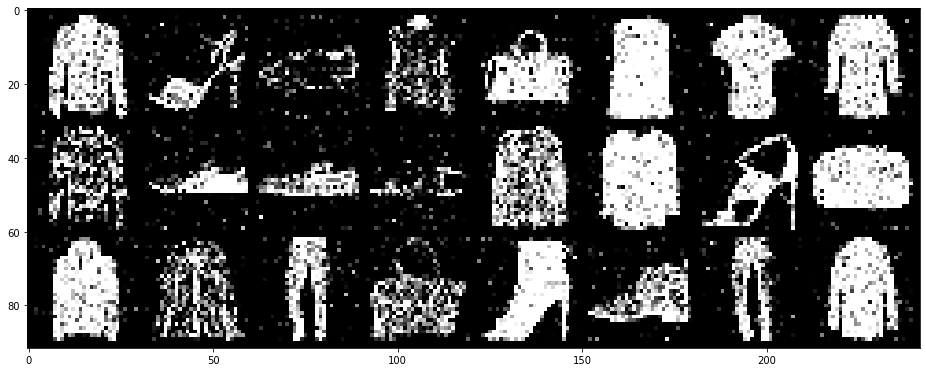

In [16]:
import numpy

samples, labels = iter(testloader).next()
test_noise = torch.tensor(np.random.normal(loc=0.5, scale=0.5, size=inputs.shape)).to('cpu')
samples = samples + test_noise
plt.figure(figsize=(16,24))
grid_imgs = torchvision.utils.make_grid(samples[:24])
np_grid_imgs = grid_imgs.numpy()
# in tensor, image is (batch, width, height), so you have to transpose it to (width, height, batch) in numpy to show it.
plt.imshow(numpy.transpose(np_grid_imgs, (1,2,0)))

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1625: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


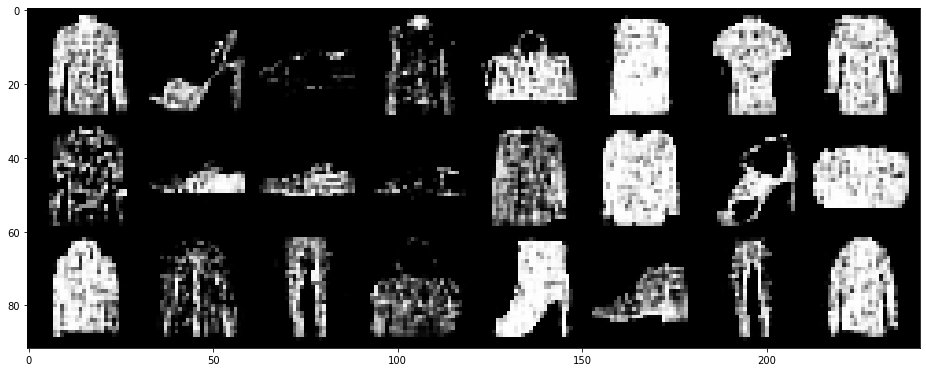

In [17]:
samples = samples.to(device='cuda', dtype=torch.float)
z_inter = encoder(samples)
Results = decoder(z_inter)
Resluts = Results.to('cpu')
plt.figure(figsize=(16,24))
grid_imgs = torchvision.utils.make_grid(Results[:24])
grid_imgs = grid_imgs.to('cpu')
np_grid_imgs = grid_imgs.detach().numpy()
# in tensor, image is (batch, width, height), so you have to transpose it to (width, height, batch) in numpy to show it.
plt.imshow(numpy.transpose(np_grid_imgs, (1,2,0)))